# Assignment 3

CS529

Adrien Clay

Christopher Jarek

Thomas Hynes

Refat Mishuk

Note: You may need to run the following command to overwrite numpy in your environment so pytorch does not throw an error.

`pip install "numpy<2"`

We were not able to use `torch.from_numpy` without this installation.

This report details the implementation of our FNN algorithm. Our analysis and tuning resulted in a maximum accuracy of 88%, additional tuning with a wider range of perameters, especially learning rates may allow our algorithm to reach 90% or greater accuracy.


## Task 1: Data Preparation

Data preparation can be found between a combination of `create_csv.py` and `load_review_data.py`

These files contain the steps for loading, processing, and returning the data used in this notebook.

## Task 2: Definition of FNN


Our model definition is located in `FNN.py`. This class implements a high level API that brings a sense of familiary with usage, similar to that you'd expect from a SciKit Learn model, with typical `.fit` and `.predict` functions, with the inclusion of `.evaulate` function that evaluates model performance on test data.

The reason for this implementation is to conveniently and quickly allow the instantiation of a PyTorch model across tasks in the assignment.


### Task 2.1: Model Definition

The definition of the model consists of the following layers:

```python
torch.nn.Linear(self.init_shape, 64),
torch.nn.ReLU(),
torch.nn.Linear(64, 32),
torch.nn.ReLU(),
torch.nn.Linear(32, 2),
torch.nn.Softmax(dim=1)
```

While this model is simple, we found that overly complex models with more layers and neurons resulted in similar or worse accuracy. With this, we were also able to train increasingly fast by altering the number of samples provided, which yielded similar results to when the number of samples was maxed out at 50,0000.

We used the loss function `CrossEntropy` as shown in the slides, adjusting the output of our model to 2 with a Softmax activation function at one dimension to appropriately accomodate binary classification.

We used the `Adam` optimizer at varying learning rates and weight decays as shown below.

Unfortunately, we are unable to achieve accuracies greater than 88%, but this varies some based on the number of input samples given. We have tried many different combinations of layers and neurons, combined with tuning all available parameters, however, we still cannot get the model to achieve accuracy greater than 88% at most.

In [1]:
from load_review_data import load_review_data
from FNN import FNN
from FNNWithDropout import FNNWithDropout
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
from k_fold_train import run_kfold
import time
from dropout_bagging import DropoutBagging
import warnings
import numpy as np
warnings.filterwarnings('ignore', category=UserWarning)

EPOCHS = 30
NUM_SAMPLES = 50000

In [2]:
# Here we load the number of samples we want from the dataset
data = load_review_data(NUM_SAMPLES)
train_dataloader = data['train_data']
test_dataloader = data['test_data']
init_shape = data['init_shape']
train_dataset = data['train_dataset']
test_dataset = data['test_dataset']
X_test = data['X_test']
y_test = data['y_test']

Class Distribution: tensor([17500, 17500])


\pagebreak

### 1.2 Results of Tuning the Model

Below we provide an implentation of tuning the model across varying learning rates and weight decays using the FNN Class.

In [3]:
learning_rates = [.001, .0001, .00001]
weight_decays = [1e-3, 1e-4, 1e-5]

combinations = [(lr, wd) for lr in learning_rates for wd in weight_decays]

final_stats = []
best_accuracy = 0
for i, (lr, wd) in enumerate(combinations):
    sys.stdout.write(f"\rTesting Combination: {i + 1}/{len(combinations)}")
    model = FNN(init_shape, learning_rate = lr, weight_decay=wd)
    model.fit(train_dataloader, verbose=-1, epochs=EPOCHS)
    accuracy = model.evaluate(test_dataloader)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        model.save_model('best_fnn.pth')
    final_stats.append({
        'learning_rate': lr,
        'weight_decay': wd,
        'time_cost': model.train_time,
        'accuracy': accuracy,
    })
    sys.stdout.flush()

Testing Combination: 9/9

In [4]:
df = pd.DataFrame(final_stats)

### Results Table

Below is a table of all results according to the learning rate and weight decay parameters. The time costs and accuracies are shown as well.

In [5]:
df

,learning_rate,weight_decay,time_cost,accuracy
0,0.00100,0.00100,43.200525,85.320000
1,0.00100,0.00010,38.972931,85.580000
2,0.00100,0.00001,37.748752,85.173333
3,0.00010,0.00100,42.526526,87.573333
4,0.00010,0.00010,38.971431,87.320000
5,0.00010,0.00001,34.535852,87.326667
6,0.00001,0.00100,35.671070,87.820000
7,0.00001,0.00010,34.105376,87.973333
8,0.00001,0.00001,33.627985,88.040000


In [6]:
df[df['accuracy'] == df['accuracy'].max()]

,learning_rate,weight_decay,time_cost,accuracy
8,0.00001,0.00001,33.627985,88.04


\pagebreak

### 1.3 Best Parameters

The best resulting parameters for learning rate and weight decay were .001 and .00001 respectively, resulting in 88% accuracy.

### Comparison

#### Weight Decay

##### Time Cost:

It's hard to say with weight decay because of the broad range of time values found during the tuning process. It appears that the time cost for training gets smaller as the weight decay values increases towards .01, but overall, the effects appear minimal.

##### Accuracy:

Again, accuracy is hard to diagnose per the plots below, as it appears that there is a broad range of accuracies discovered as weight decay shifts around. It is highly likely that weight decay and learning rate together make the largest difference rather than being able to evaluate by weight decay alone.


#### Learning Rate

##### Time Cost: 

Similarily to weight decay, time cost appears to decrease as learning rate increases towards .1. The range of values is somewhat broad, but the pattern appears relatively clear. A further exploration of even smaller learning rates may result in even greater accuracy.

##### Accuracy:

Accuracy appears to increase significantly as learning rate approaches .1. This would make sense, because the model likely has the ability to stagnate if the learning rate is too slow, meaning it's not learning fast enough over the given number of epochs to make a good prediction.


#### Comparison to LogisticRegression from Textbook

Overall, the model from the textbook performed better than what we were able to achieve here. The model in the textbook achieved 89% accuracy, we managed to max out any model in this notebook at about 88%.

\pagebreak

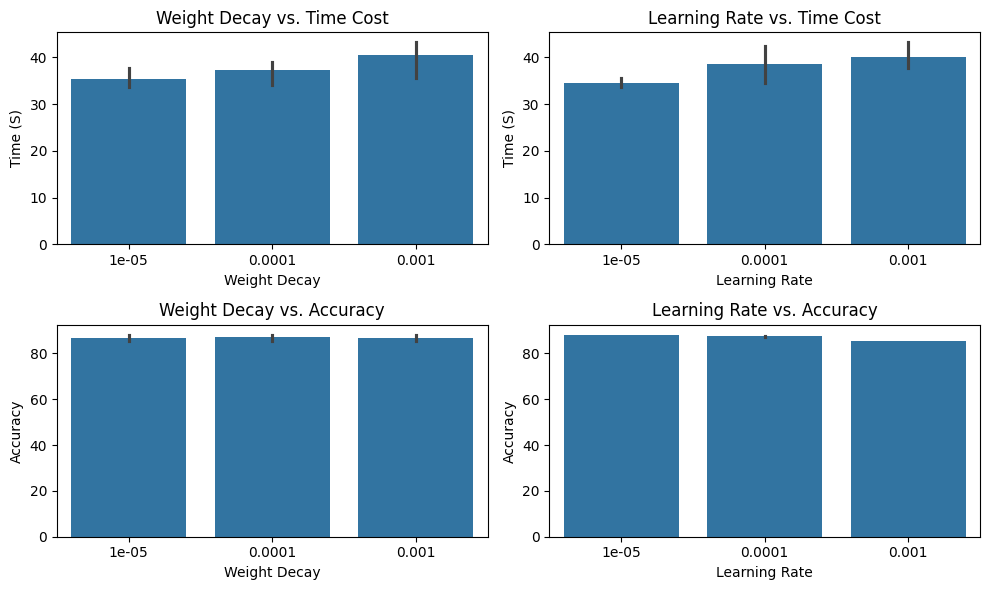

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(10,6))

sns.barplot(ax=axes[0, 0], data=df.sort_values('weight_decay'), x='weight_decay', y='time_cost')
axes[0,0].set_title("Weight Decay vs. Time Cost")
axes[0,0].set_xlabel("Weight Decay")
axes[0,0].set_ylabel("Time (S)")

sns.barplot(ax=axes[0, 1], data=df.sort_values('learning_rate'), x='learning_rate', y='time_cost')
axes[0,1].set_title("Learning Rate vs. Time Cost")
axes[0,1].set_xlabel("Learning Rate")
axes[0,1].set_ylabel("Time (S)")

sns.barplot(ax=axes[1, 0], data=df.sort_values('weight_decay'), x='weight_decay', y='accuracy')
axes[1,0].set_title("Weight Decay vs. Accuracy")
axes[1,0].set_xlabel("Weight Decay")
axes[1,0].set_ylabel("Accuracy")

sns.barplot(ax=axes[1, 1], data=df.sort_values('learning_rate'), x='learning_rate', y='accuracy')
axes[1,1].set_title("Learning Rate vs. Accuracy")
axes[1,1].set_xlabel("Learning Rate")
axes[1,1].set_ylabel("Accuracy")

plt.tight_layout()

\pagebreak

## Task 4: KFold Training

Below are the results using 5 folds to train the `FNN` model with KFold Cross Validation

The output of the below cell is captured to avoid its extremely long output

In [8]:
%%capture
start = time.time()
results, time_costs = run_kfold(train_dataset=train_dataset, test_dataset=test_dataset, init_shape=init_shape, k=5, epochs=EPOCHS)
end = time.time()

total_time = end - start

In [9]:
print(f"TOTAL TRAIN TIME: {total_time}s")
print(f"AVERAGE MODEL TRAIN TIME: {np.mean(time_costs)}s", )

print(f'K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS')
print('-'*10)

sum = 0.0

for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value

print(f'Average: {sum/len(results.items())} %')

TOTAL TRAIN TIME: 210.84757590293884s
AVERAGE MODEL TRAIN TIME: 41.95864834785461s
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
----------
Fold 0: 87.96 %
Fold 1: 87.76 %
Fold 2: 87.41 %
Fold 3: 87.53 %
Fold 4: 87.87 %
Average: 87.70599999999999 %


\pagebreak

## Task 5: FNN With Dropout

Below, we have implementated a training loop to tune parameters on the class `FNNWithDropout`, which is a copy of `FNN` that includes dropout layers in the model definition.

In [10]:
learning_rates = [.0001, .00001]
weight_decays = [1e-3, 1e-4, 1e-5]
dropouts = [.3, .5, .75]

combinations = [(lr, wd, d) for lr in learning_rates for wd in weight_decays for d in dropouts]

final_stats = []
best_accuracy = 0
dropout_time_costs = []
for i, (lr, wd, d) in enumerate(combinations):
    sys.stdout.write(f"\rTesting Combination: {i + 1}/{len(combinations)}")
    model = FNNWithDropout(init_shape, learning_rate = lr, weight_decay=wd, dropout_prob=d)
    model.fit(train_dataloader, verbose=-1, epochs=EPOCHS)
    dropout_time_costs.append(model.train_time)
    accuracy = model.evaluate(test_dataloader)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        model.save_model('best_dropout.pth')
    final_stats.append({
        'learning_rate': lr,
        'weight_decay': wd,
        'dropout_rate': d,
        'time_cost': model.train_time,
        'accuracy': accuracy,
    })
    sys.stdout.flush()



Testing Combination: 18/18

In [11]:
dropout_df = pd.DataFrame(final_stats)

# 

\pagebreak

### Results

We can see the parameters for all models below, and subsequently for the best model.

In [17]:
dropout_df

,learning_rate,weight_decay,dropout_rate,time_cost,accuracy
0,0.00010,0.00100,0.30,50.917193,87.993333
1,0.00010,0.00100,0.50,50.413063,88.140000
2,0.00010,0.00100,0.75,50.517874,88.060000
3,0.00010,0.00010,0.30,45.292134,88.113333
4,0.00010,0.00010,0.50,46.701754,87.913333
5,0.00010,0.00010,0.75,47.415892,88.073333
6,0.00010,0.00001,0.30,41.902961,87.893333
7,0.00010,0.00001,0.50,42.049798,87.906667
8,0.00010,0.00001,0.75,42.954729,88.180000
9,0.00001,0.00100,0.30,45.388324,50.000000


In [12]:
dropout_df[dropout_df['accuracy'] == dropout_df['accuracy'].max()]

,learning_rate,weight_decay,dropout_rate,time_cost,accuracy
8,0.0001,0.00001,0.75,42.954729,88.18


### Time Cost

Below is the average time cost across training all instances of the `FNNWithDropout` models in our tuning procedure above in seconds, which amounts to about 44 seconds to train the model. So far, this is holding true for all models trained across this notebook.

In [16]:
print(np.mean(dropout_time_costs))

44.39766800403595


\pagebreak

## Training With Bagging

The high-level API implementation `DropoutBagging` combines `FNNWithDropout` with an ensemble learning method using random subsets of the train and test data. 

By using `torch.data.utils.RandomSampler`, we are able to train 5 models on random subsets of the data, and add them to the ensemble of methods that will ultiamtely output the prediction.

When provided an array, `db.predict()` will run the prediction logic getting raw probability output from `FNNWithDropout` using it's in-built `predict_proba` method (named similarily to that found in some Scikit Learn models) and return the probabilities which are then summed. After summing, using `np.argmax` can generate the predictions as usual from the ensemble of model predictions.

As mentioned above, we are unable to produce models achieving greater than ~88%, and the following case is no different.

In [14]:
db = DropoutBagging(num_models=5, learning_rate=.0001, weight_decay=.00001, dropout_prob=.3)
db.fit(train_dataset=train_dataset, test_dataset=test_dataset, init_shape=init_shape, epochs=EPOCHS, verbose = 0)

Training Model 1/5
Epoch 30/30
Training Model 2/5
Epoch 30/30
Training Model 3/5
Epoch 30/30
Training Model 4/5
Epoch 30/30
Training Model 5/5
Epoch 30/30


In [15]:
print("TOTAL TRAIN TIME:", db.train_time)
print()
preds = db.predict(X_test)
print(classification_report(y_test.detach().numpy(), preds))

TOTAL TRAIN TIME: 236.54496550559998

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      7500
           1       0.87      0.89      0.88      7500

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000

